The purpose of this notebook is to calculate the total number of genes that are affected by this artifact in at least one depmap cell line.

In [55]:
#Define arguments/parameters
working_dir = "/home/jupyter/notebooks/Ancestry"
workspace_bucket = Sys.getenv('WORKSPACE_BUCKET')
out_directory = "avana14" #the output directory name

In [56]:
#Set up the environment

#load packages
library(dplyr)
library(tidyverse)
library(stringr)
library(plyr)

#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

In [57]:
#Load in the depmap avana subset data matrix
paste(working_dir, "/raw_data/depmap/", out_directory, sep = "") %>% setwd()
avana.subset <- read.table("depmap_avana_collapsed_guide_snp_matrix.txt", header = T, sep = "\t")
avana.subset[1:10, 1:10]
dim(avana.subset)

,gene,sgrna,chr,pos,ACH.002214,ACH.001020,ACH.000317,ACH.000382,ACH.000172,ACH.000527
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,OR4F17,TCTCCATTCGGTGAGCCAGT,chr1,69534,0,0,0,0,0,0
2,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939354,0,0,0,0,0,0
3,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939355,0,0,0,0,0,0
4,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939356,0,0,0,0,0,0
5,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939358,0,0,0,0,0,0
6,NOC2L,CCATCTCTCAACCATGGCGA,chr1,956930,0,0,0,0,0,0
7,KLHL17,GCCCGCCTCCTGCAGCCCCG,chr1,961286,0,0,0,0,0,0
8,KLHL17,GCCCGCCTCCTGCAGCCCCG,chr1,961297,0,0,0,0,0,0
9,KLHL17,GCGTGGCCCACAACTCCAAG,chr1,961388,0,0,0,0,0,0


[1] 79727  1760

In [58]:
###Get a list of all of the depmap cell lines so that we can filter the snpxguidexgene matrix

system(glue::glue("
cd {working_dir}/raw_data/depmap/{out_directory}
gsutil cp gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514/public-21q2_v12-achilles-gene-effect-chronos.csv .
"))

paste(working_dir, "/raw_data/depmap/", out_directory, sep = "") %>% setwd()
chronos.scores <- read.table("public-21q2_v12-achilles-gene-effect-chronos.csv", header = T, sep = ",")
dim(chronos.scores)
chronos.scores[1:10, 1:10]

depmap.lines <- chronos.scores$DepMap_ID
length(depmap.lines)

[1]   859 18026

,DepMap_ID,A1BG..1.,A1CF..29974.,A2M..2.,A2ML1..144568.,A3GALT2..127550.,A4GALT..53947.,A4GNT..51146.,AAAS..8086.,AACS..65985.
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000004,0.085182601,0.0311078975,-0.229675206,-0.019110816,0.13843968,-0.11563144,0.140267813,-0.3509937,0.165627805
2,ACH-000005,-0.047515207,0.0928010733,-0.021927211,0.113849328,0.10571153,-0.16697496,0.110861598,-0.3855129,-0.056164911
3,ACH-000007,-0.027968175,-0.0289905830,-0.031672575,0.026763633,0.05416951,0.10409471,-0.044521638,-0.3915746,-0.094925558
4,ACH-000009,0.046814250,0.0278182974,-0.002840993,-0.023859065,0.20715597,-0.05366645,-0.001123352,-0.4840048,0.100083671
5,ACH-000011,0.114031959,0.0743680409,0.008924388,0.206204953,0.03532976,-0.18891784,0.045605508,-0.2180298,0.123186802
6,ACH-000012,-0.061480923,0.0981230719,0.133786682,0.214367474,0.19614445,-0.16747406,0.198516306,-0.2784515,0.046055645
7,ACH-000013,-0.018547341,0.0124748861,-0.046895743,0.076004211,0.01881837,-0.08705845,-0.000464505,-0.3697191,-0.021785995
8,ACH-000014,0.004555722,-0.0009708097,-0.019447556,0.045663269,0.07207041,-0.09673752,-0.214836681,-0.2667910,-0.153605237
9,ACH-000015,-0.130280851,0.0607801493,-0.153261480,0.015946307,0.08015174,-0.01342187,0.140680801,-0.3805728,0.006709002


[1] 859

In [59]:
#Correct avana.subset so that the . in the title is converted back to a -
colnames(avana.subset) <- gsub("\\.", "-", colnames(avana.subset)) #R replaced the '-' with '.' on loading, so fix that


#filter avana.subset so that it only has cell lines that were included in depmap
columns.to.keep <- c("gene", "sgrna", "chr", "pos", depmap.lines) #Get a vector of columns that we want to keep
columns.to.keep <- intersect(columns.to.keep, colnames(avana.subset))
avana.subset <- avana.subset[, columns.to.keep]


#Filter the dataset so that it only includes guides that have a SNP in at least one cell line
row.sum.vector <- rowSums(avana.subset[,5:ncol(avana.subset)]) %>% as.vector()
avana.subset <- avana.subset[row.sum.vector >= 1,]
avana.subset[1:10, 1:10]


,gene,sgrna,chr,pos,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,OR4F17,TCTCCATTCGGTGAGCCAGT,chr1,69534,0,0,0,0,0,0
2,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939354,0,0,0,0,0,0
3,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939355,0,0,0,0,0,0
4,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939356,0,0,0,0,0,0
5,SAMD11,GCTTGTGTCAGCACTGAGCG,chr1,939358,0,0,0,0,0,0
7,KLHL17,GCCCGCCTCCTGCAGCCCCG,chr1,961286,0,0,0,0,0,0
8,KLHL17,GCCCGCCTCCTGCAGCCCCG,chr1,961297,0,0,0,0,0,0
9,KLHL17,GCGTGGCCCACAACTCCAAG,chr1,961388,0,0,0,0,0,0
10,KLHL17,GCGTGGCCCACAACTCCAAG,chr1,961395,0,0,0,0,0,0


In [60]:
#Filter the dataset to remove certain "genes" like "POTENTIALLY_ACTIVE_23"
start.genes <- nrow(avana.subset)
avana.subset <- avana.subset[!grepl("_",avana.subset$gene),]
end.genes <- nrow(avana.subset)
print(paste("There were ", start.genes-end.genes, " genes that were cut from the data frame."))

[1] "There were  102  genes that were cut from the data frame."


In [61]:
###Calculate the total number of genes that are affected
affected.gene.number <- avana.subset$gene %>% unique %>% length()

print(paste("There are ", affected.gene.number, " genes that are affected by this artifact in at least one cell line!", sep = ""))


#Load in the chip file and calculate the total number of genes in depmap
paste(working_dir, "/raw_data/depmap/", out_directory, sep = "") %>% setwd()
chip.file <- read.table("avana14_guide_to_gene.chip", header = T, sep = "\t")
colnames(chip.file) <- c("sgrna", "gene", "geneid")
chip.file <- chip.file[!grepl("_", chip.file$gene),] #Remove the non-targeting guides
total.genes <- chip.file$gene %>% unique() %>% length()
print(paste("There are", total.genes, " genes in the entire dataset!"))
print(paste((affected.gene.number/total.genes)*100, "% of genes in the dataset are affected!"))

[1] "There are 15408 genes that are affected by this artifact in at least one cell line!"
[1] "There are 21447  genes in the entire dataset!"
[1] "71.8422156945027 % of genes in the dataset are affected!"


In [62]:
#Collapse the dataset so that we can make a figure


#First, drop the columns that we don't need 
avana.subset.collapsed <- avana.subset[,-c(2,3,4)]
dim(avana.subset.collapsed)

#Just like we did above, collapse the dataset by gene names
show_msg(glue::glue("Collapsing by gene name"))
avana.subset.collapsed <- aggregate(. ~ gene, data = avana.subset.collapsed, FUN = sum)


#Convert all of the numbers that are greater than 1 to be 1. A number greater than 1 means that there are multiple SNPs in that guide. But we just want a binary indicator of whether or not there is a SNP in that guide
show_msg(glue::glue("Recoding gene-level matrix"))
gene <- avana.subset.collapsed$gene #Take a vector of the sgrna labels
avana.subset.collapsed[avana.subset.collapsed > 1] <- 1 #Convert all of the numbers larger than 1 to be equal to 1
avana.subset.collapsed$gene <- gene #Assign the sgrna names back to the matrix
colnames(avana.subset.collapsed)[1] <- "gene"


dim(avana.subset.collapsed)





[1] 44846   850

Collapsing by gene name
Recoding gene-level matrix


[1] 15408   850

In [70]:
#Create a named vector that has the number of affected cell lines for each gene
affected.lines <- rowSums(avana.subset.collapsed[,-1]) %>% data.frame()
dim(affected.lines)
colnames(affected.lines) <- "num.affected"


[1] 15408     1

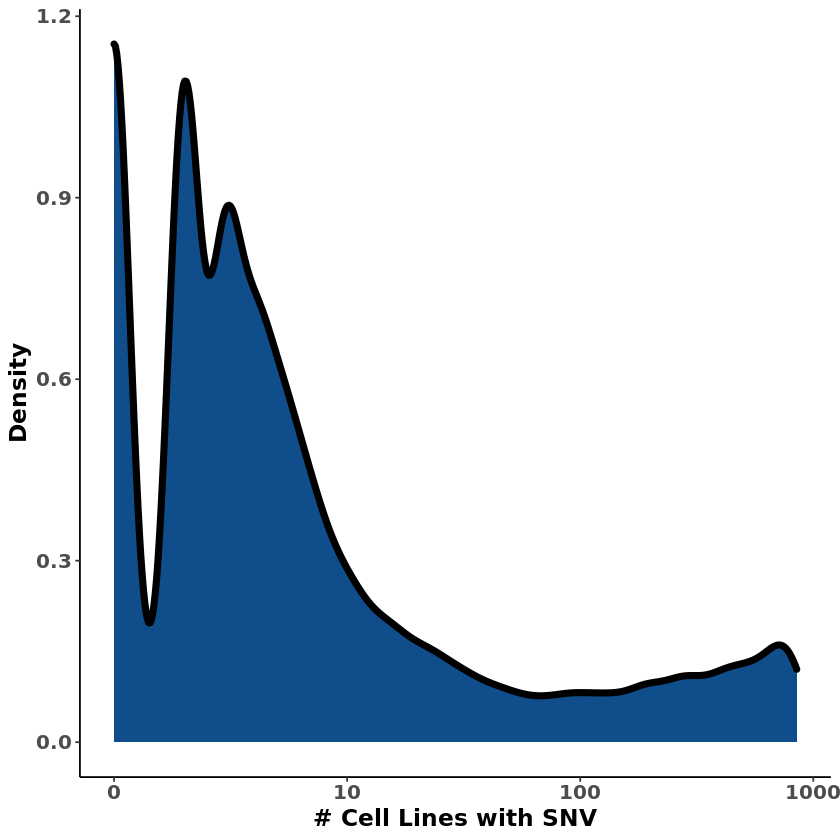

In [77]:
###Now, let's make a figure to illustrate this. I think the best figure might just be a histogram


ggplot(affected.lines, aes(x=log10(num.affected))) +
	geom_density(alpha = 1, fill = "dodgerblue4", size = 2) +
	
theme_bw() +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
  legend.title = element_text(size = 14, face = "bold"),
  legend.text = element_text(size = 10, face = "bold")
  ) +
  
ylab("Density") +
xlab("# Cell Lines with SNV") +

scale_x_continuous(labels=c(0, 10, 100, 1000))


In [78]:
#Save the plot

paste(working_dir, "/figures", sep ="") %>% setwd()
ggsave("depmap_affected_lines_per_gene.tiff") #save the plot

system(glue::glue("
cd {working_dir}/figures
gsutil cp depmap_affected_lines_per_gene.tiff gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Saving 6.67 x 6.67 in image

